# Dataset presentation
Welcome to the dataset notebook. This notebook aims to describe how to create a dataset and use it to store your analysis properties. The idea here is to store in a file all the parameters required to perform correlation codes without executing the entire notebook in a well (or not that well) defined order.

In [1]:
## - imports
from heliumtools.dataset import Dataset
from heliumtools.tools import apply_ROI
import os
from heliumtools.misc.some_plots_volume1 import stability_of_sequence
import pandas as pd


# define the dataset path (location where to save files)
DATASET_PATH = "/mnt/manip_E/DATASETS/COSQUA/2022-11-18"

## Dataset instanciation

When instanciating the class, you must gives it a valid directory or at least a directory in which it can creates a folder that will be the data location. 
All parameters of your dataset are then stored in a nice readble `yaml` file called 'properties.yml' that is readen when you instanciate the class. 
Important parameters are:
* `name` : it is *where* your data are stored. 
* `sequences`: the list of sequences that are stored in the dataset
* `filters` : filter you want to apply before loading data and metadatas
* `raw_ROI` : one has to be carrefull as we have always a thousand definition for the ROIs. Here, the roi hat is used to choose atoms in (X, Y, T) is defined as raw_ROI. The attribut ROI is kept for the ROI defined in momentum space. 

The method that can be used are :
* `set(**kwargs)` is the method to set an argument
* `load(filtered = True)` returns you the data and matadatas of the dataset. If you want to appy the filters you previously defined, it is possible.
* `add_filter(key, val)` is a method that can be used to add a filter to the filters. You can also use `set(filters={.....})` 
* `get_dataset_properties` show you all your dataset entries
* `save_parameters` save your class parameters in the yaml file.
I give an exemple below.



In [2]:
dataset = Dataset(DATASET_PATH)
# set the properties you are interested in
dataset.set(raw_ROI={"T": [301, 312]}, fit_arrival_times = True)
dataset.set(fit_roi = {  # roi to fit BEC arrival time
            "T": {"min": 306.2, "max": 309.7},
            "X": [-30, 0],
            "Y": [-15, 15],
        })
dataset.set(fit_arrival_times = True, 
            fit_histogram_width = 0.01, 
            fit_width_saturation = 0.0)
dataset.get_dataset_properties()

INFO:Dataset was initialized in folder /mnt/manip_E/DATASETS/COSQUA/2022-11-18
INFO:The file parameter does not exist. Creating it with default parameters.
INFO:Requiring dataset properties...


name                : /mnt/manip_E/DATASETS/COSQUA/2022-11-18
sequences           : []
raw ROI             : {'T': [301, 312]}
raw ROD             : {}
metadata to gather  : ['picoscope', 'bec', 'param']
supplementary rois  : []
filters             : {}
fit roi             : {'T': {'min': 306.2, 'max': 309.7}, 'X': [-30, 0],
fit arrival times   : True
fit histogram width : 0.01
fit width saturation: 0.0


## Add the sequences to the dataset
Once a sequence is added to the dataset, there is no need to re-add it. 

One can add a sequence to the dataset using the `add_sequence_to_dataset` method. This method use the usual `export_dataset_to_pickle` function, passing it the following arguments:
```
export_data_set_to_pickle(
            folder=seq_dir,
            ROI=self.raw_ROI,
            ROD=self.raw_ROD,
            find_arrival_times=self.fit_arrival_times,
            n_max_cycles=1e8,
            histogramm_width=self.fit_histogram_width,
            ROI_for_fit=self.fit_roi,
            width_saturation=self.fit_width_saturation,
            supplementary_rois=self.supplementary_rois,
            metadata=self.metadata_to_gather,
        )
```

**Reminder of the export_data_set_to_pickle arguments**

* folder: path
    *    Path to the folder containing all the .atoms files.
* ROI: dictionary
    * Region of Interest: we will only select atoms within this ROI. It can be empty, and in that case, we keep all atoms (and not none). Example: {"T": {"min": 300, "max": 350}}. The format of this dictionary must match the official format of an ROI (see the apply_ROI function for more details).
* ROD: dictionary
    * Region of Disinterest: we exclude all atoms within this region. WARNING: this function currently acts axis by axis.
* find_arrival_times: boolean
    * If True, fit the arrival time of the BEC. If False, do not perform the fit.
* n_max_cycles: int
    * Maximum number of cycles to select. Not often useful.
* histogram_width: float,
    * In ms, width of the bins in the histogram for fitting according to T and .times.
* width_saturation: float,
    * Saturation width during which there is no signal due to TDC saturation. Histogram points between tmax, the time at which the signal is maximal, and tmax + dt are removed and not considered in the fit.
* supplementary_rois: list of ROIs
    * Additional ROIs in which we want to count atoms (to apply filters during sequence analysis, for example). Data from these ROIs will be added to the datafbec arrival_times.
* metadata: list of string
    * List of metadata to load with the sequence parameters.

In [3]:
# sequence directory to add
root_seq_dir = os.path.join("/mnt", "manip_E", "2022", "11", "18" )
# you can add many sequences to this dataset
seq_folders = ["083"]
for seq in seq_folders:
    dataset.add_sequence_to_dataset(os.path.join(root_seq_dir,seq))
print(dataset.sequences)

Starting to gather atoms from /mnt/manip_E/2022/11/18/083


261it [00:28,  4.69it/s]/home/victor/vikenv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/victor/vikenv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/victor/vikenv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/victor/vikenv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
262it [00:28,  9.16it/s]
INFO:Sequence /mnt/manip_E/2022/11/18/083 was succesfully added to the dataset.


['2022-11-18-083']


In [4]:
# try to add this sequence again to the dataset : it should not be possible.
# a priori, I tried to code the dataset class as Windows and Linux compatible.
for seq in seq_folders:
    dataset.add_sequence_to_dataset(os.path.join(root_seq_dir,seq))

## Definition of the filters for datas
We can now check the sequence stability and filter out datas

{'BEC Arrival Time': [307.65, 307.75]}


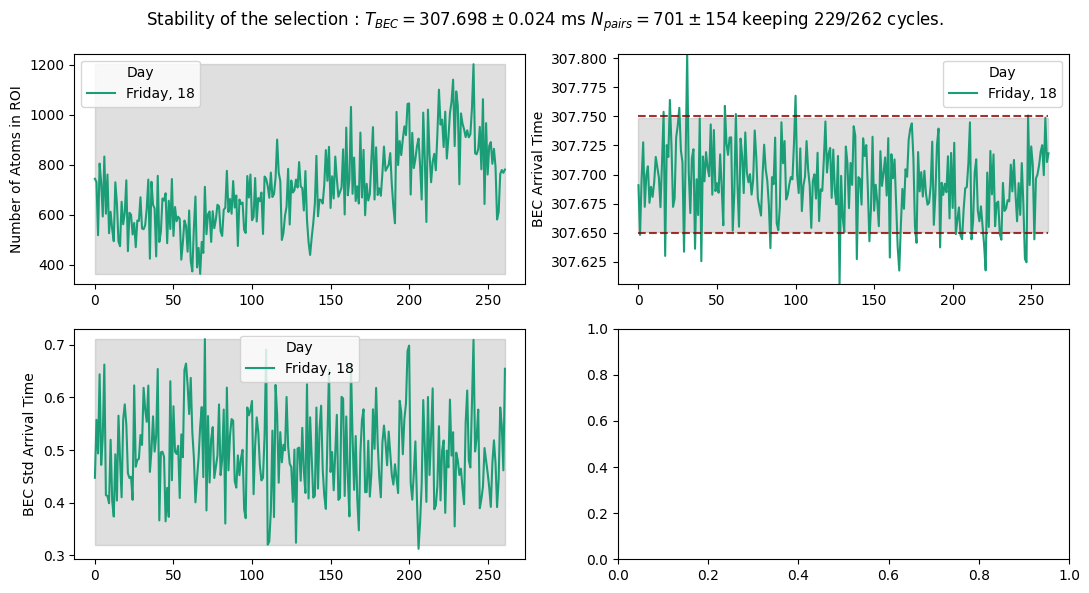

In [7]:
all_metadata = dataset.load_metadata()
#dataset.add_filter("Number of Atoms in ROI", [750,1700])
dataset.add_filter("BEC Arrival Time", [307.65,307.75])
columns_to_plot= ["Number of Atoms in ROI","BEC Arrival Time", "BEC Std Arrival Time"]
print(dataset.filters)
selected_data = apply_ROI(all_metadata, dataset.filters)
stability_of_sequence(all_metadata,columns_to_plot = columns_to_plot,
                      selec_bec_arrival_times = selected_data,
                     filters = dataset.filters)


In [8]:
# set the BEC mean arrival time for building the momentum dataframe
dataset.set(BEC_arrival_time = 307.694)

## Some more informations about dataset properties

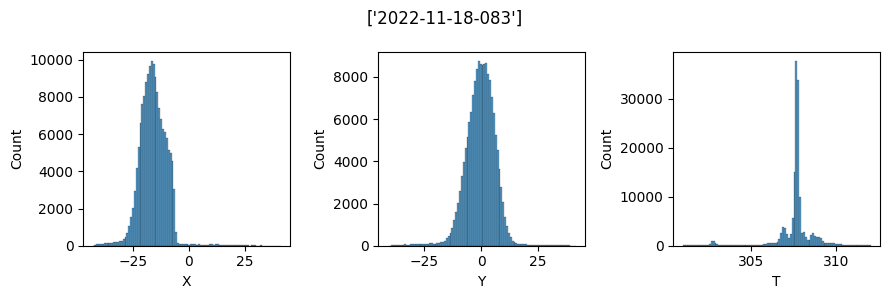

In [12]:
# load data 
# filtered option ables to filter data with the 
# filters registered before (default is True)
data, metadata = dataset.load(filtered=True)
import matplotlib.pyplot as plt
import seaborn as sns
data, metadata = dataset.load(filtered=True)

# plot datas
fig, axes = plt.subplots(figsize = (9,3), ncols = 3)
for i, col in enumerate(["X", "Y", "T"]):
    ax = axes[i]
    sns.histplot(data = data, x = col, bins = 100, ax = ax)
fig.suptitle(str(dataset.sequences))
plt.tight_layout()


In [9]:
# if you modify a parameter in the ymlproperties file, 
# you can reload in order not to overwrite it after
dataset.load_parameters()

In [10]:
# add a variable and delete it
dataset.set(troisieme_var = 3)
print(dataset.troisieme_var)
# remove this variable
dataset.remove("troisieme_var")
# this will raise an AttributeError as troisieme_var was removed
dataset.troisieme_var


3


AttributeError: 'Dataset' object has no attribute 'troisieme_var'

In [ ]:
# Suppress all sequences from the dataset : 
#dataset.clean_up_dataset()

In [11]:
# show properties
dataset.get_dataset_properties()

INFO:Requiring dataset properties...


name                : /mnt/manip_E/DATASETS/COSQUA/2022-11-18
sequences           : ['2022-11-18-083']
raw ROI             : {'T': [301, 312]}
raw ROD             : {}
metadata to gather  : ['picoscope', 'bec', 'param']
supplementary rois  : []
filters             : {'BEC Arrival Time': [307.65, 307.75]}
fit roi             : {'T': {'max': 309.7, 'min': 306.2}, 'X': [-30, 0],
fit arrival times   : True
fit histogram width : 0.01
fit width saturation: 0.0
BEC arrival time    : 307.694
